<a href="https://colab.research.google.com/github/ankitaggarwal64/Agricultural-Equipment-Sales-Forecasting/blob/main/Univariate_ARIMA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
#import libraries
import warnings
import itertools
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
#import sales and indices combined data
combined_sales_ind = pd.read_csv("/content/drive/My Drive/1. Data Science/Sales Forecasting_Masters Project/Masters Project/Data/Output_files/combined_sales_ind.csv",parse_dates=['Time'], index_col='Time')

In [4]:
sales = combined_sales_ind["Sales"]

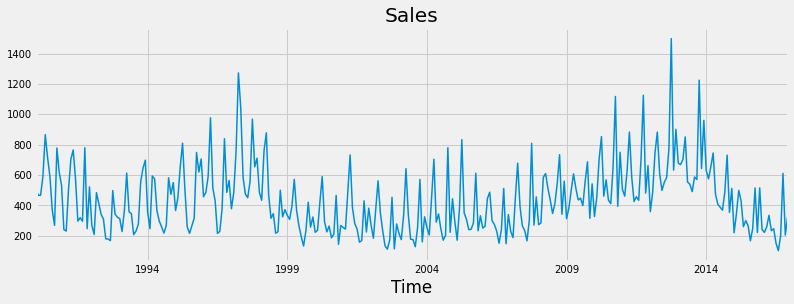

In [5]:
# Line plot of Sales time series
plt.style.use("fivethirtyeight")
ax = sales.plot(subplots= False,linewidth=1.5,sharex=False,sharey=False, figsize=(12,4),fontsize=10)
plt.title("Sales")
plt.show()

## Obseravtion : There is clear cyclicity and seasonality

In [6]:
# Train and Test Split
split_point = len(sales)-12
train,test = sales[0:split_point],sales[split_point:]
print('Train %d, Test %d' % (len(train),len(test)))

Train 312, Test 12


In [7]:
train.head

<bound method NDFrame.head of Time
1990-01-31    505
1990-02-28    467
1990-03-31    467
1990-04-30    593
1990-05-31    866
             ... 
2015-08-31    167
2015-09-30    249
2015-10-31    515
2015-11-30    222
2015-12-31    516
Name: Sales, Length: 312, dtype: int64>

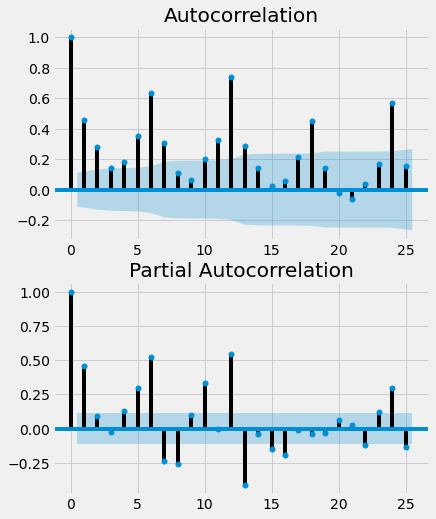

In [8]:
#ACF and PACF plots
from pandas import read_csv
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from matplotlib import pyplot
import pylab
pylab.rcParams['figure.figsize'] = (6,8)
pyplot.figure()
pyplot.subplot(211)
plot_acf(train, lags=25, ax=pyplot.gca())
pyplot.subplot(212)
plot_pacf(train, lags=25, ax=pyplot.gca())
pyplot.show()

#OBSERVATIONS:
#There is a clear seasonality of 12 as seen in the peaks of ACF plot
#There is a possibility of both AR and MA terms because of geometric decay on ACF plot and significant autocorrelation of particular lags

In [9]:
# Define the p, d and q parameters to take any value between 0 and 2
p = range(0, 3)
d = range(0, 2)
q = range(0, 2)


# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


In [ ]:
warnings.filterwarnings("ignore") # specify to ignore warning messages

columns = ['param','param_seasonal','aic']
rows = []

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(train,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()
            row = [param, param_seasonal, results.aic]
            rows.append(row)

            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

models_aic = pd.DataFrame(rows, columns=columns)

In [12]:
mod = sm.tsa.statespace.SARIMAX(train,
                                order=(2, 0, 1),
                                seasonal_order=(0, 1, 0, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit()

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


In [13]:
print(results.summary())

                                 Statespace Model Results                                 
Dep. Variable:                              Sales   No. Observations:                  312
Model:             SARIMAX(2, 0, 1)x(0, 1, 0, 12)   Log Likelihood               -1845.144
Date:                            Mon, 23 Nov 2020   AIC                           3698.287
Time:                                    05:57:43   BIC                           3713.076
Sample:                                01-31-1990   HQIC                          3704.207
                                     - 12-31-2015                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0777      0.172      6.282      0.000       0.741       1.414
ar.L2         -0.1680      0.129   

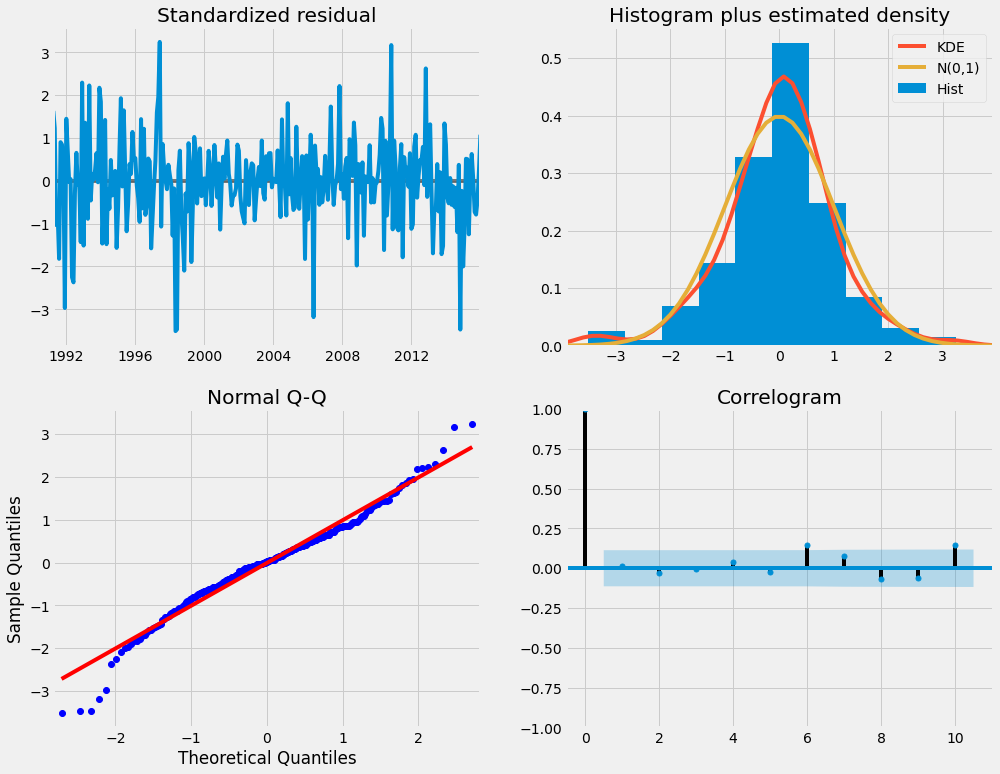

In [14]:
results.plot_diagnostics(figsize=(15, 12))
plt.show()

In [15]:
pred_dynamic = results.get_prediction(start=pd.to_datetime('2015-01-31'), dynamic=True, full_results=True)
pred_dynamic_ci = pred_dynamic.conf_int()

In [16]:
pred_dynamic.predicted_mean

2015-01-31    344.636109
2015-02-28    341.639089
2015-03-31    451.610880
2015-04-30    565.008345
2015-05-31    314.189109
2015-06-30    266.007534
2015-07-31    262.820407
2015-08-31    256.868729
2015-09-30    386.352294
2015-10-31    642.445938
2015-11-30    275.304518
2015-12-31    442.065553
Freq: M, dtype: float64

In [17]:
pred_dynamic_ci

,lower Sales,upper Sales
2015-01-31,112.390961,576.881257
2015-02-28,86.642391,596.635787
2015-03-31,185.965742,717.256017
2015-04-30,292.096671,837.920020
2015-05-31,35.808163,592.570055
2015-06-30,-16.595668,548.610736
2015-07-31,-23.069516,548.710330
2015-08-31,-31.589763,545.327221
2015-09-30,95.881461,676.823127
2015-10-31,350.395700,934.496176


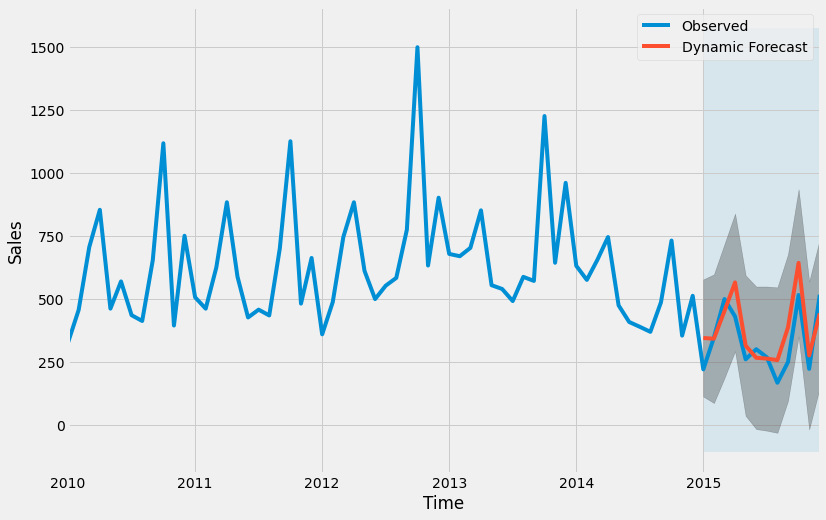

In [18]:
ax = train['2010':].plot(label='Observed', figsize=(12, 8))
pred_dynamic.predicted_mean.plot(label='Dynamic Forecast', ax=ax)

ax.fill_between(pred_dynamic_ci.index,
                pred_dynamic_ci.iloc[:, 0],
                pred_dynamic_ci.iloc[:, 1], color='k', alpha=.25)

ax.fill_betweenx(ax.get_ylim(), pd.to_datetime('2015-01-31'), train.index[-1],
                 alpha=.1, zorder=-1)

ax.set_xlabel('Time')
ax.set_ylabel('Sales')

plt.legend()
plt.show()

In [19]:
from sklearn.metrics import mean_squared_error
from math import sqrt

# Extract the predicted and true values of our time series
y_forecasted = pred_dynamic.predicted_mean
y_truth = train['2015-01-31':]

# report performance
# Compute the Root mean squared error
rmse = sqrt(mean_squared_error(y_truth, y_forecasted))
print('RMSE: %.3f' % rmse)

forecast_errors = y_truth-y_forecasted
bias = sum(forecast_errors)*1.0/len(forecast_errors)
print('Bias: %.3f' % bias)

percent_forecast_errors = abs(y_truth-y_forecasted)*100/y_truth 
MAPE = sum(percent_forecast_errors)*1.0/len(percent_forecast_errors)
print('MAPE: %.3f' % MAPE)

RMSE: 87.387
Bias: -46.412
MAPE: 25.415


In [20]:
# Test
# Get forecast 12 steps ahead in future
pred_uc = results.get_forecast(steps=12)

# Get confidence intervals of forecasts
pred_ci = pred_uc.conf_int()

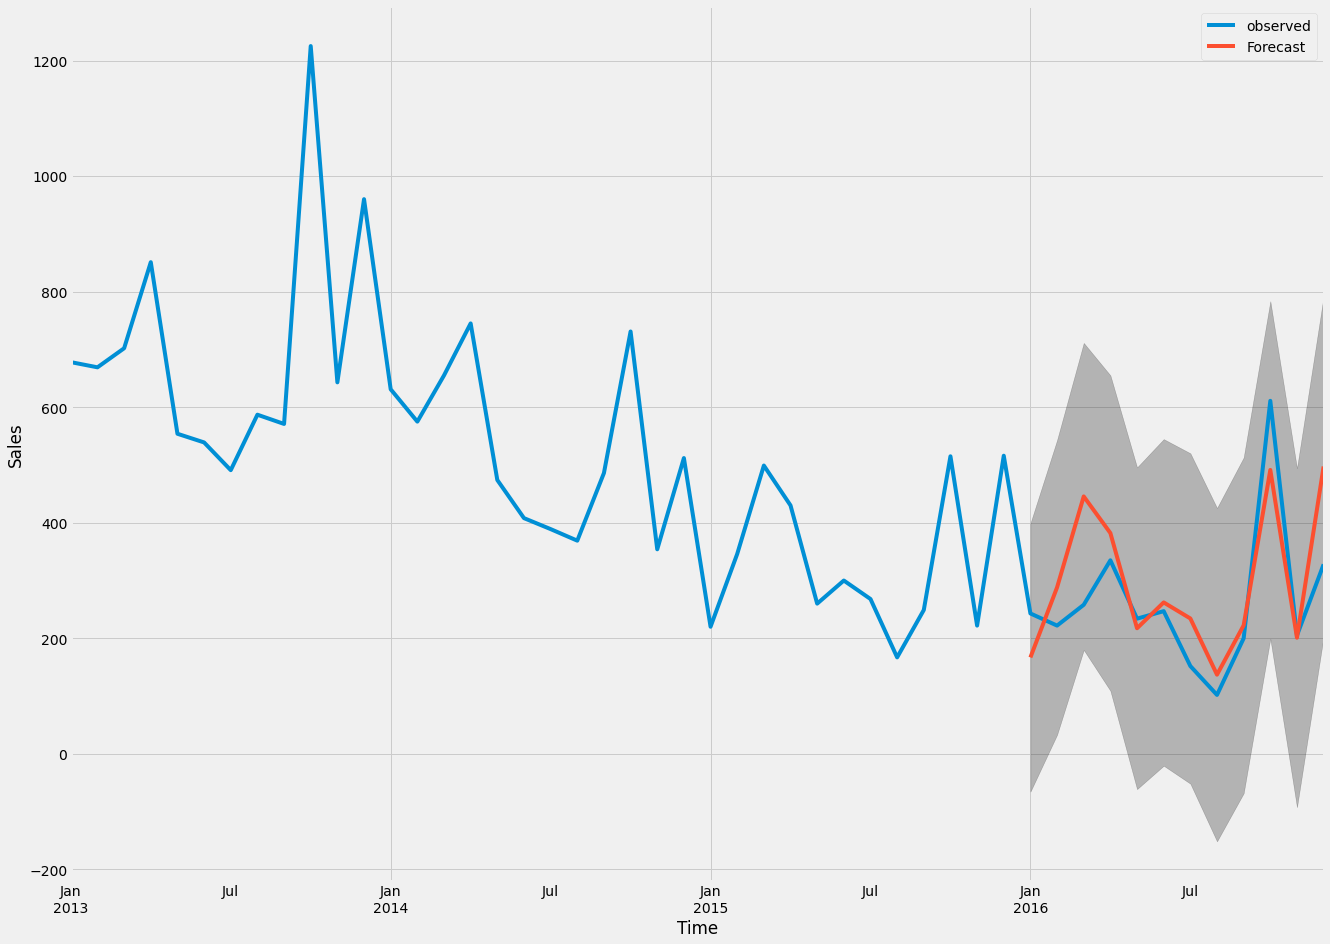

In [21]:
ax = sales['2013':].plot(label='observed', figsize=(20, 15))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Time')
ax.set_ylabel('Sales')

plt.legend()
plt.show()

In [22]:
# Extract the predicted and true values of our time series
y_forecasted = pred_uc.predicted_mean
y_truth = test

# report performance
# Compute the Root mean squared error
rmse = sqrt(mean_squared_error(y_truth, y_forecasted))
print('RMSE: %.3f' % rmse)

forecast_errors = y_truth-y_forecasted
bias = sum(forecast_errors)*1.0/len(forecast_errors)
print('Bias: %.3f' % bias)

percent_forecast_errors = abs(y_truth-y_forecasted)*100/y_truth 
MAPE = sum(percent_forecast_errors)*1.0/len(percent_forecast_errors)
print('MAPE: %.3f' % MAPE)

RMSE: 91.091
Bias: -34.058
MAPE: 27.832
